### Классификация
#### 1. Импортируем библиотеки и датасет (геометрические свойства трех видов пшеницы).

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, plotly.express as px
from sklearn import tree,ensemble,model_selection,metrics,neighbors
from warnings import filterwarnings as fw
fw('ignore')

In [3]:
data = pd.read_csv('seeds.csv')
data.head()

,area,perimeter,compactness,kernellength,kernelwidth,assymetry,groovelength,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


Отберем в отдельные датафреймы характеристики объектов и метки классов. 
<br>Затем поделим датасет на обучающую и тестовую выборки.

In [4]:
x = data.iloc[:,:7]
y = data.iloc[:,7:]
xtrain,xtest,ytrain,ytest = model_selection.train_test_split(x,y,test_size=0.2)
print('xtrain: ', xtrain.shape, 'ytrain: ', ytrain.shape, '\nxtest: ', xtest.shape, 'ytest: ', ytest.shape)
ytest=ytest.to_numpy().flatten()

xtrain:  (168, 7) ytrain:  (168, 1) 
xtest:  (42, 7) ytest:  (42, 1)


#### 2. Построим дерево решений со значениями по умолчанию.

In [5]:
DTC = tree.DecisionTreeClassifier()
DTC.fit(xtrain,ytrain)
ypred = DTC.predict(xtest)

Оценим результат с помощью таких метрик, как precision, recall, f1-score, а также AUC и матриц ошибок.

In [6]:
print(metrics.classification_report(ytest,ypred,digits=5))
print('AUC (area under ROC curve) = ', metrics.roc_auc_score(ytest,DTC.predict_proba(xtest),average='macro',multi_class='ovr'))

              precision    recall  f1-score   support

           1    0.61538   0.80000   0.69565        10
           2    1.00000   1.00000   1.00000        11
           3    0.88889   0.76190   0.82051        21

    accuracy                        0.83333        42
   macro avg    0.83476   0.85397   0.83872        42
weighted avg    0.85287   0.83333   0.83779        42

AUC (area under ROC curve) =  0.8850694444444445


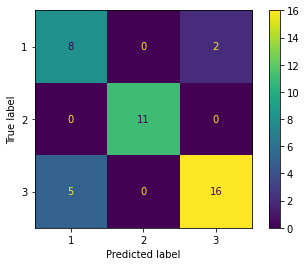

In [7]:
metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(ytest,ypred), display_labels=DTC.classes_).plot()

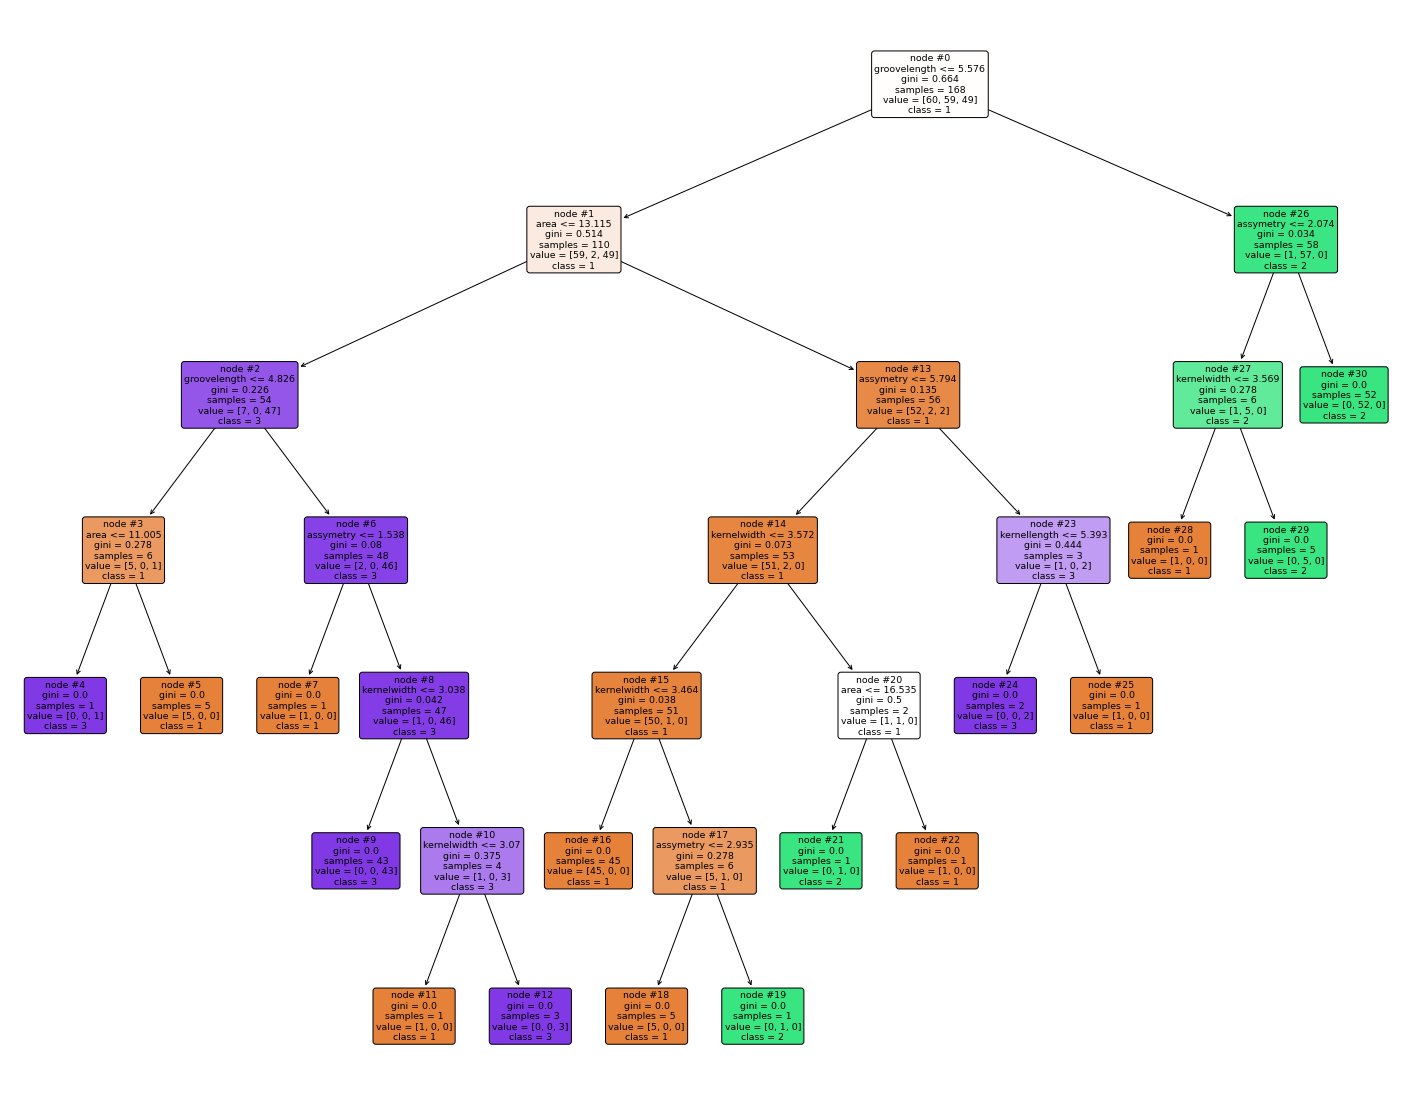

In [8]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(DTC, 
                   feature_names=['area','perimeter','compactness','kernellength','kernelwidth','assymetry','groovelength'],  
                   class_names=['1','2','3'],
                   filled=True,
                   rounded=True, 
                   node_ids=True)

##### Построим дерево решений с максимальной числом уровней в 2.

In [9]:
DTC = tree.DecisionTreeClassifier(max_depth=2)
DTC.fit(xtrain,ytrain)
ypred = DTC.predict(xtest)
print(metrics.classification_report(ytest,ypred,digits=5))
print('AUC (area under ROC curve) = ', metrics.roc_auc_score(ytest,DTC.predict_proba(xtest),average='macro',multi_class='ovr'))

              precision    recall  f1-score   support

           1    0.75000   0.60000   0.66667        10
           2    1.00000   1.00000   1.00000        11
           3    0.82609   0.90476   0.86364        21

    accuracy                        0.85714        42
   macro avg    0.85870   0.83492   0.84343        42
weighted avg    0.85352   0.85714   0.85245        42

AUC (area under ROC curve) =  0.9023620559334846


Матрица ошибок:

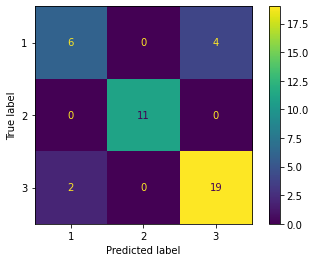

In [10]:
metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(ytest,ypred), display_labels=DTC.classes_).plot()

Участвующие показатели и их важность:

In [11]:
for i in range(7):
    if DTC.feature_importances_[i] !=0:
        print(data.columns[i], ' - ', DTC.feature_importances_[i])

area  -  0.40754189385156614
assymetry  -  0.0033155428214601754
groovelength  -  0.5891425633269737


Дерево решений:

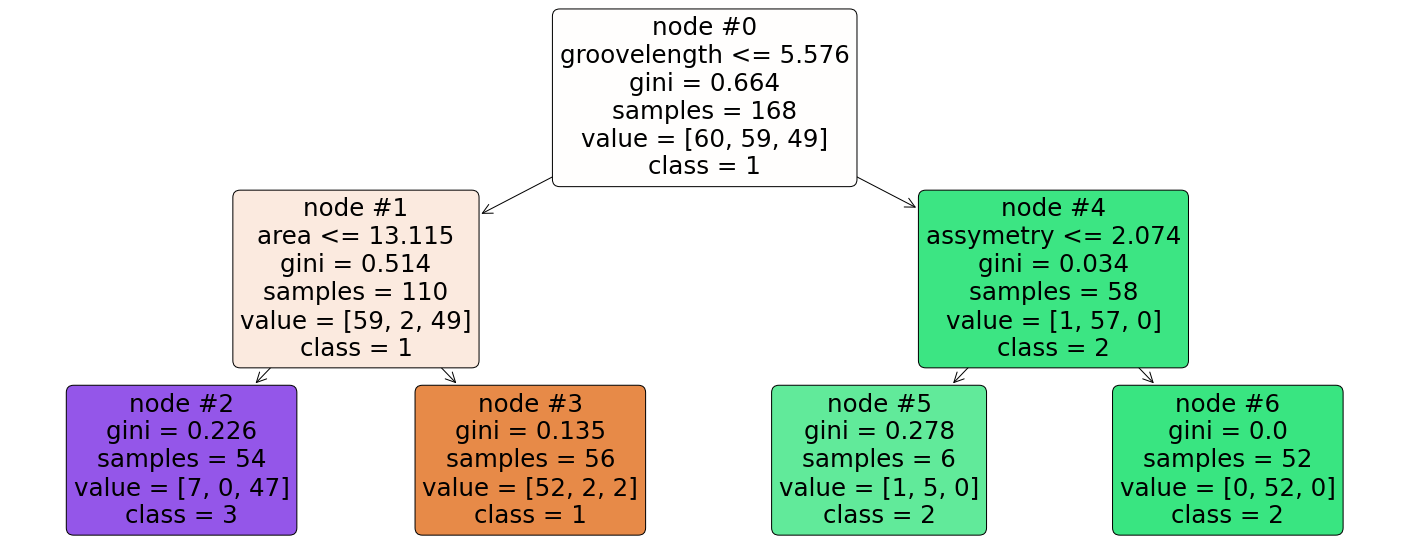

In [12]:
fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(DTC, 
                   feature_names=['area','perimeter','compactness','kernellength','kernelwidth','assymetry','groovelength'],  
                   class_names=['1','2','3'],
                   filled=True,
                   rounded=True, 
                   node_ids=True)

##### Построим дерево решений с минимальным числом объектов узла в 6.

In [13]:
DTC = tree.DecisionTreeClassifier(min_samples_leaf=10)
DTC.fit(xtrain,ytrain)
ypred = DTC.predict(xtest)
print(metrics.classification_report(ytest,ypred,digits=5))
print('AUC (area under ROC curve) = ', metrics.roc_auc_score(ytest,DTC.predict_proba(xtest),average='macro',multi_class='ovr'))

              precision    recall  f1-score   support

           1    0.56250   0.90000   0.69231        10
           2    1.00000   1.00000   1.00000        11
           3    0.93333   0.66667   0.77778        21

    accuracy                        0.80952        42
   macro avg    0.83194   0.85556   0.82336        42
weighted avg    0.86250   0.80952   0.81563        42

AUC (area under ROC curve) =  0.9425205498866213


Матрица ошибок:

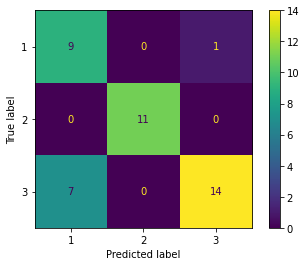

In [14]:
metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(ytest,ypred), display_labels=DTC.classes_).plot()

Дерево решений:

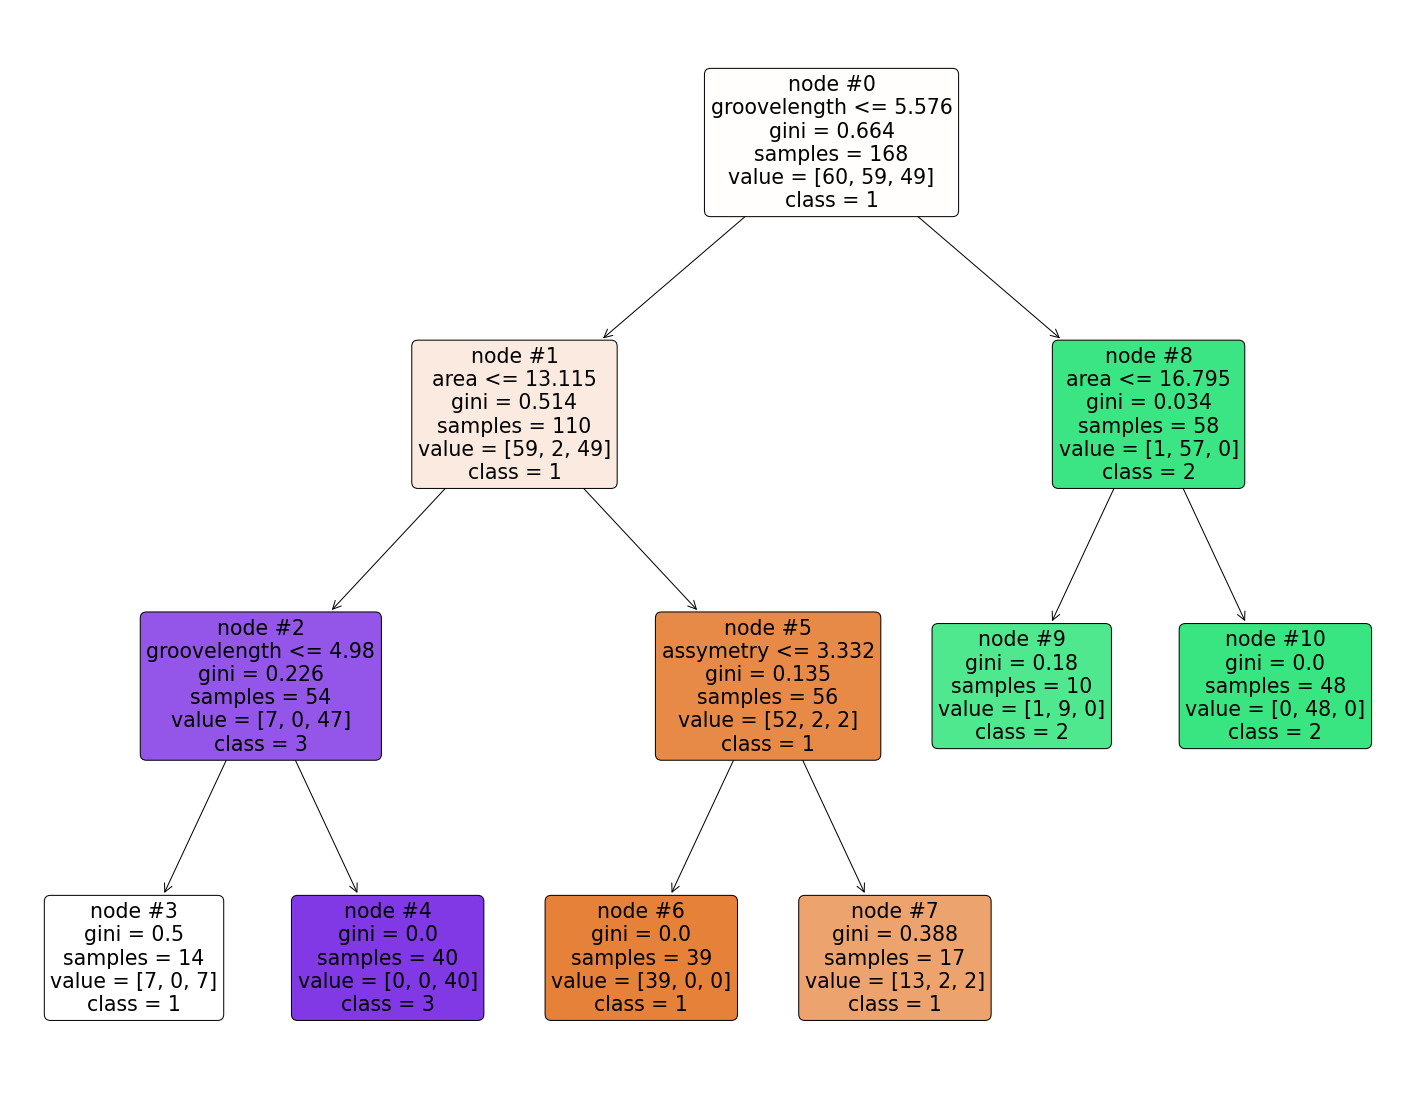

In [15]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(DTC, 
                   feature_names=['area','perimeter','compactness','kernellength','kernelwidth','assymetry','groovelength'],  
                   class_names=['1','2','3'],
                   filled=True,
                   rounded=True, 
                   node_ids=True)

In [16]:
KNN = neighbors.KNeighborsClassifier()
KNN.fit(xtrain,ytrain)
ypredKNN = KNN.predict(xtest)
print(metrics.classification_report(ytest,ypredKNN,digits=5))

              precision    recall  f1-score   support

           1    1.00000   0.60000   0.75000        10
           2    1.00000   1.00000   1.00000        11
           3    0.84000   1.00000   0.91304        21

    accuracy                        0.90476        42
   macro avg    0.94667   0.86667   0.88768        42
weighted avg    0.92000   0.90476   0.89700        42



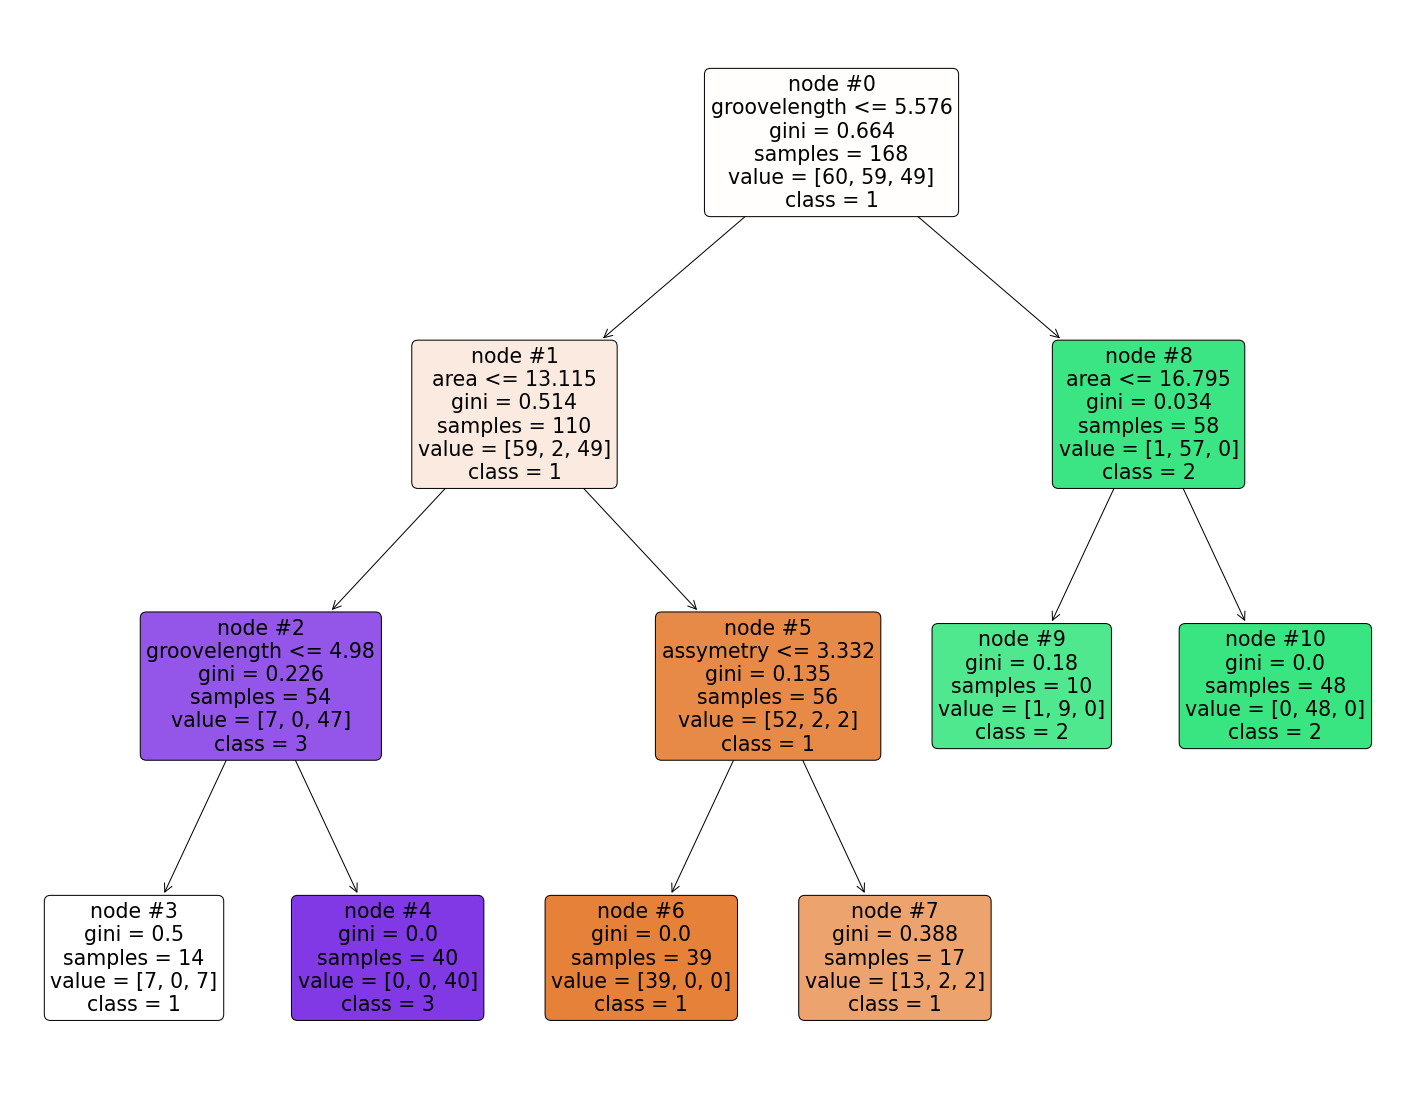

In [17]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(DTC, 
                   feature_names=['area','perimeter','compactness','kernellength','kernelwidth','assymetry','groovelength'],  
                   class_names=['1','2','3'],
                   filled=True,
                   rounded=True, 
                   node_ids=True)


In [18]:
RFC = ensemble.RandomForestClassifier()
RFC.fit(xtrain,ytrain.to_numpy().flatten())
ypredRFC = RFC.predict(xtest)
print(metrics.classification_report(ytest,ypredRFC,digits=5))

              precision    recall  f1-score   support

           1    0.80000   0.80000   0.80000        10
           2    1.00000   1.00000   1.00000        11
           3    0.90476   0.90476   0.90476        21

    accuracy                        0.90476        42
   macro avg    0.90159   0.90159   0.90159        42
weighted avg    0.90476   0.90476   0.90476        42



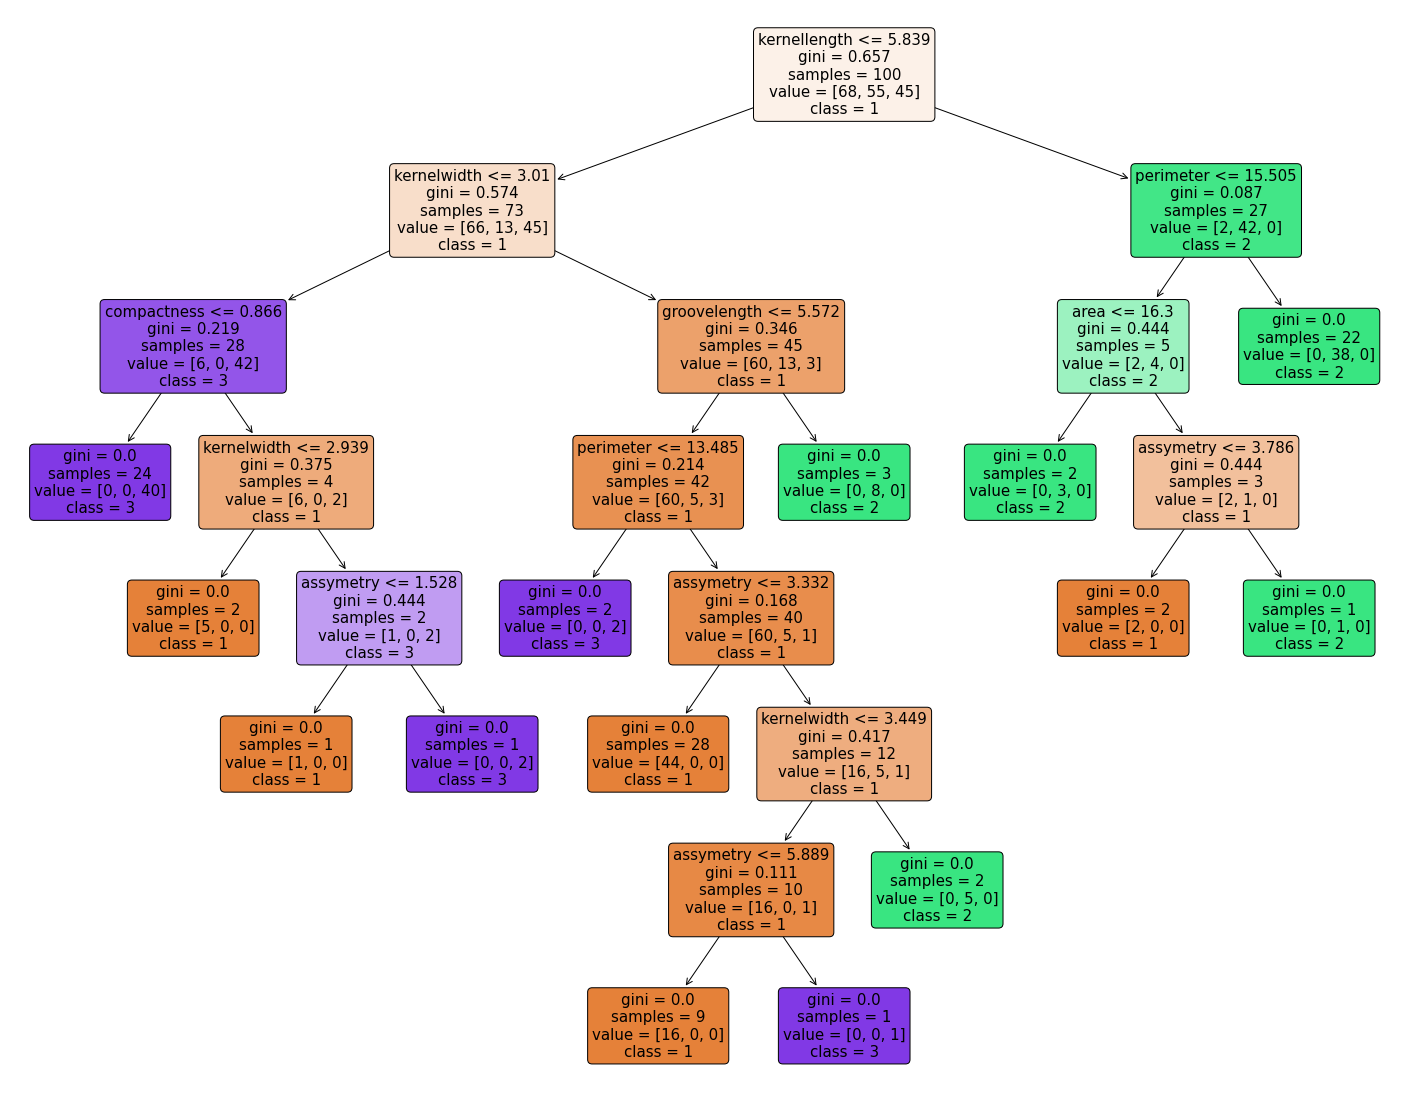

In [19]:
fig = plt.figure(figsize=(25,20))
a = tree.plot_tree(RFC.estimators_[0], 
                   feature_names=['area','perimeter','compactness','kernellength','kernelwidth','assymetry','groovelength'],  
                   class_names=['1','2','3'],
                   filled=True,
                   rounded=True)

#### 3. Исследуем влияние параметров на качество классификации.

#### 4. Оценим важность показателей с помощью RandomForest.

In [20]:
for i in range(7):
    print(data.columns[i], ' - ', RFC.feature_importances_[i])

area  -  0.17950311411803266
perimeter  -  0.2067712132286127
compactness  -  0.07845950860432874
kernellength  -  0.11044358571220514
kernelwidth  -  0.14858489096122476
assymetry  -  0.07474553327670515
groovelength  -  0.20149215409889087


Таким образом, наши показатели в порядке убывания важности:
<br> perimeter > groovelength > kernelwidth > area > kernellength > assymetry > compactness
<br> Построим диаграммы размаха для трех наиболее важных показателей.

In [21]:
px.box(data[['perimeter','class']], x='class', y='perimeter', title='perimeter distribution by classes')

In [22]:
px.box(data[['groovelength','class']], x='class', y='groovelength', title='groovelength distribution by classes')

In [23]:
px.box(data[['kernelwidth','class']], x='class', y='kernelwidth', title='kernelwidth distribution by classes')

#### 5. Построение моделей Decision tree на полном наборе показателей, на 20% самых важных, на 80% наименее важных.

#### 6. Коллективные древовидные модели на базе бустинга: AdaBoost и GradientBoost
Используем AdaBoost со значениями по умолчанию:
<br> Оценим результат с помощью таких метрик, как precision, recall, f1-score, а также AUC и матриц ошибок.

In [24]:
ABC = ensemble.AdaBoostClassifier()
ABC.fit(xtrain,ytrain)
ABCpred = ABC.predict(xtest)
print(metrics.classification_report(ytest,ABCpred,digits=5))
print('AUC (area under ROC curve) = ', metrics.roc_auc_score(ytest,ABC.predict_proba(xtest),average='macro',multi_class='ovr'))

              precision    recall  f1-score   support

           1    0.32258   1.00000   0.48780        10
           2    1.00000   1.00000   1.00000        11
           3    0.00000   0.00000   0.00000        21

    accuracy                        0.50000        42
   macro avg    0.44086   0.66667   0.49593        42
weighted avg    0.33871   0.50000   0.37805        42

AUC (area under ROC curve) =  0.8301339285714285


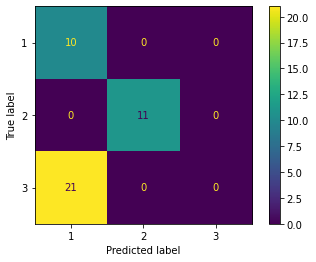

In [25]:
metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(ytest,ABCpred), display_labels=DTC.classes_).plot()

Теперь используем дерево решений, построенное в пункте 2 в качестве базового классификатора, чтобы получить лучший результат.

In [26]:
ABC = ensemble.AdaBoostClassifier(base_estimator=DTC)
ABC.fit(xtrain,ytrain)
ABCpred = ABC.predict(xtest)
print(metrics.classification_report(ytest,ABCpred,digits=5))
print('AUC (area under ROC curve) = ', metrics.roc_auc_score(ytest,ABC.predict_proba(xtest),average='macro',multi_class='ovr'))

              precision    recall  f1-score   support

           1    0.88889   0.80000   0.84211        10
           2    1.00000   1.00000   1.00000        11
           3    0.90909   0.95238   0.93023        21

    accuracy                        0.92857        42
   macro avg    0.93266   0.91746   0.92411        42
weighted avg    0.92809   0.92857   0.92752        42

AUC (area under ROC curve) =  0.983536470143613


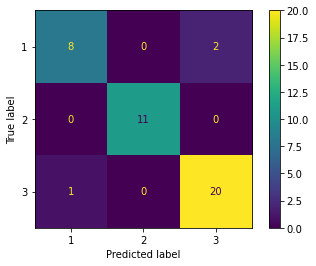

In [27]:
metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(ytest,ABCpred), display_labels=DTC.classes_).plot()

Используем GradientBoost со значениями по умолчанию:

In [28]:
GBC = ensemble.GradientBoostingClassifier()
GBC.fit(xtrain,ytrain)
GBCpred = GBC.predict(xtest)
print(metrics.classification_report(ytest,GBCpred,digits=5))
print('AUC (area under ROC curve) = ', metrics.roc_auc_score(ytest,GBC.predict_proba(xtest),average='macro',multi_class='ovr'))

              precision    recall  f1-score   support

           1    0.77778   0.70000   0.73684        10
           2    1.00000   1.00000   1.00000        11
           3    0.86364   0.90476   0.88372        21

    accuracy                        0.88095        42
   macro avg    0.88047   0.86825   0.87352        42
weighted avg    0.87891   0.88095   0.87920        42

AUC (area under ROC curve) =  0.9806972789115647


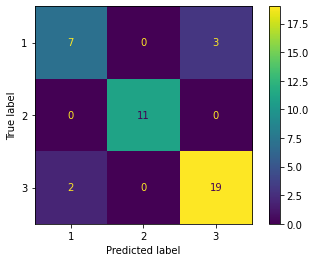

In [29]:
metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(ytest,GBCpred), display_labels=DTC.classes_).plot()